# Project description

## Context
<a id="the_top"></a>

I am an analyst at a big online store. Together with the marketing department, I have compiled a list of hypotheses that may help boost revenue. I need to prioritize these hypotheses, launch an A/B test, and analyze the results.

## Description of the data

/datasets/hypotheses_us.csv:

    Hypotheses — brief descriptions of the hypotheses
    Reach — user reach, on a scale of one to ten
    Impact — impact on users, on a scale of one to ten
    Confidence — confidence in the hypothesis, on a scale of one to ten
    Effort — the resources required to test a hypothesis, on a scale of one to ten. The higher the Effort value, the more resource-intensive the test.

/datasets/orders_us.csv:

    transactionId — order identifier
    visitorId — identifier of the user who placed the order
    date — of the order
    revenue — from the order
    group — the A/B test group that the user belongs to

/datasets/visits_us.csv:

    date — date
    group — A/B test group
    visits — the number of visits on the date specified in the A/B test group specified

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import seaborn as sn
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats as st

In [2]:
pd.set_option('max_colwidth',400)

max_colwidth sets the maximum width of columns.

In [3]:
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv',sep=';')
hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


There are 9 hypothesis in the frame.

In [4]:
hypotheses.columns = hypotheses.columns.str.lower()
hypotheses.head()

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1


I put the name of columns in lowercase.

In [5]:
orders = pd.read_csv('/datasets/orders_us.csv')
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A
1195,1947021204,1614305549,2019-08-14,5.5,A


There are 1197 transactions made. Every transaction had visitor´s ID, date of the transaction, order size of the transaction and the group in which a certain visitor belongs to (A or B).

In [6]:
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null float64
group            1197 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 174.3 KB


In [7]:
orders['date'] = pd.to_datetime(orders['date'],dayfirst=True)

I coverted the date values from object type to daytime.

In [8]:
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null float64
group            1197 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 105.3 KB


In [9]:
double_visitors = orders.groupby(['visitorId'])['group'].nunique().reset_index().query('group>1')
double_visitors.head()

,visitorId,group
2,8300375,2
44,199603092,2
51,232979603,2
55,237748145,2
66,276558944,2


double_visitors frame contains list of visitors who made orders in both groups, so I will exclude them from A/B testing.

In [10]:
len(double_visitors)

58

There are all together 58 double visitors.

In [11]:
orders_clean = orders[~orders['visitorId'].isin(double_visitors['visitorId'])]
orders_clean

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


orders_clean is table of orders where I excluded double visitor´s purchases.

In [12]:
visits = pd.read_csv('/datasets/visits_us.csv')
visits

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


Here visits from double visitor are already included. It could effect the conversion rate.

## Part 1. Prioritizing Hypotheses

Prioritizing Using ICE Score:

You calculate the score this way:

ICE score = Impact * Confidence * Ease

    Impact - is an estimate of how much the idea will positively affect the key metric you’re trying to improve.
    
    Ease (of implementation) - is an estimation of how much effort and resources will be required to implement this idea. This is typically the inverse of effort (person-week) 
    
    Confidence - indicates how sure we are about Impact, and to some degree also about ease of implementation. Confidence values are the antidote — they keep us honest about our assumptions.
    
    
Prioritizing Using RICE Score:

You calculate the score this way:

RICE score = (Reach * Impact * Confidence) / Effort

    Reach - is an estimation of how many users will be affected by the update that we want to introduce
    
    Effort - is an estimation ofh ow much will it cost to test the hypothesis
    
    
In RICE framework we don´t use the Ease estimation, but Reach. The final score we get dividing by Effort. Usually lower effort means higher Ease.
    

### Apply the ICE framework to prioritize hypotheses. Sort them in descending order of priority.

In [13]:
hypotheses['ice_score'] = ((hypotheses['impact']*hypotheses['confidence']) / hypotheses['effort']).round(2)
hypotheses = hypotheses.sort_values(by='ice_score',ascending=False)
hypotheses

,hypothesis,reach,impact,confidence,effort,ice_score
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.20
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.33
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.20
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.00
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.00
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.00
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.33
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.12
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.00


According to the ice_score first four hypothesis in prioritizing are hypothesis with ordinal number 8, 0 and 7.

It is imortant to point out the Effort variable. For business is better to have the smallest possible value.<br>

### Apply the RICE framework to prioritize hypotheses. Sort them in descending order of priority.

In [14]:
hypotheses['rice_score'] = (hypotheses['reach']*hypotheses['impact']*hypotheses['confidence'])/hypotheses['effort']
hypotheses = hypotheses.sort_values(by='rice_score',ascending=False)
hypotheses

,hypothesis,reach,impact,confidence,effort,ice_score,rice_score
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.20,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.00,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.33,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.00,40.0
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.20,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.12,9.0
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.00,4.0
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.33,4.0
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.00,3.0


We can see here how prioritizig changed after the hypotheses are sorted by the 'rice_score'. Now the first three hypothesis are hypothesis 7, 2 and 0. The best looking hypothesis 8 from ICE framework is now on the 5th place by the RICE framework, but it has the same value for both (16.2) because the reach value is very low; only 1.

### Show how the prioritization of hypotheses changes when you use RICE instead of ICE . Provide an explanation for the changes.

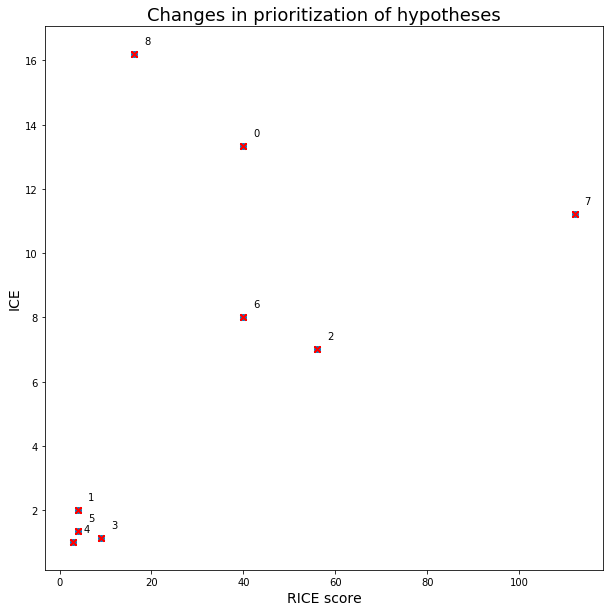

In [15]:
x = hypotheses['rice_score'].values
y = hypotheses['ice_score'].values
types = hypotheses.index.values

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y)

ax.set_xlabel('RICE score', fontsize=14)
ax.set_ylabel('ICE', fontsize=14)
ax.set_title('Changes in prioritization of hypotheses', fontsize=18)

for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
    plt.scatter(x, y, marker='x', color='red')

From this chart we can clearly see which hypothesis has the best scores. We already saw that hypothesis 8 has the highest ICE score but low RICE score because of small Reach value.<br>

Hypothesis 0 has high ICE score has high ICE score. RICE score is a bit higher than for hypothesis 8.<br>

Hypothesis 7 has the higest RICE score with lower ICE than by hypothesis 8 and 0.<br>

We could say hypothesis 6 and 2 are somewhere in the middle with the scores and hypothesis 1, 3, 4 and 5 with very low scores both ICE and RICE.

## Part 2. A/B Test Analysis

We carried out an A/B test and got the results described in the files orders_us.csv and visits_us.csv.

Analyze the A/B test:
1. Graph cumulative revenue by group. Make conclusions and conjectures.
2. Graph cumulative average order size by group. Make conclusions and conjectures.
3. Graph the relative difference in cumulative average order size for group B compared with group A. Make conclusions and conjectures.
4. Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make conjectures.
5. Plot a scatter chart of the number of orders per user. Make conclusions and conjectures.
6. Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.
7. Plot a scatter chart of order prices. Make conclusions and conjectures.
8. Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.
9. Find the statistical significance of the difference in conversion between the groups using the raw data. Make conclusions and conjectures.
10. Find the statistical significance of the difference in average order size between the groups using the raw data. Make conclusions and conjectures.
11. Find the statistical significance of the difference in conversion between the groups using the filtered data. Make conclusions and conjectures.
12. Find the statistical significance of the difference in average order size between the groups using the filtered data. Make conclusions and conjectures.
13. Make a decision based on the test results. The possible decisions are:
    Stop the test, consider one of the groups the leader.
    Stop the test, conclude that there is no difference between the groups.
    Continue the test.

In [16]:
orders_by_users_A = orders_clean[orders_clean['group']=='A'].groupby('visitorId',as_index=False)\
    .agg({'transactionId':pd.Series.nunique})

orders_by_users_A.columns = ['visitorId','transactions']
orders_by_users_A

,visitorId,transactions
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1
...,...,...
440,4227830084,1
441,4237561104,1
442,4243832526,1
443,4259830713,1


I extracted users from group A and counted their orders/transactions.

In [17]:
orders_by_users_B = orders_clean[orders_clean['group']=='B'].groupby('visitorId',as_index=False)\
    .agg({'transactionId':pd.Series.nunique})

orders_by_users_B.columns = ['visitorId','transactions']
orders_by_users_B

,visitorId,transactions
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1
...,...,...
523,4251115836,1
524,4258103007,1
525,4279090005,1
526,4281247801,1


I extracted users from group B and counted their orders/transactions. There are more orders in group B; 83 more.

### Graph cumulative revenue by group. Make conclusions and conjectures.

In [18]:
orders_clean.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [19]:
datesGroups = orders_clean[['date','group']].drop_duplicates()
datesGroups

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


In [20]:
datesGroups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 1150
Data columns (total 2 columns):
date     62 non-null datetime64[ns]
group    62 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 1.5+ KB


This frame tells us there were orders from both group on every day.

In [21]:
ordersAggregated = (datesGroups\
    .apply(lambda x: orders_clean[ np.logical_and( orders_clean['date'] <= x['date'], orders_clean['group'] == x['group'] )]\
    .agg({'date':'max','group':'max','transactionId':pd.Series.nunique,'visitorId': pd.Series.nunique,'revenue':'sum'}),axis=1)\
    .sort_values(by=['date','group'])
)

With this code, it is as if we have been calculating the results of our test every day up to the current date and storing them in the rows of the ordersAggregated table.

In the first part of the code, we get the rows of the orders_clean table where the date is less than or equal to the date of the datesGroups element and the test group is the same as in datesGroups: orders[np.logical_and(orders_clean['date'] <= x['date'], orders_clean['group'] == x['group'])]

In the second part, we aggregate the values. We find the maximum date. We'll find the maximum value for the group, too, so that we have the 'group' column in our final output. We find the number of unique transactions and visitor IDs and calculate the sum of purchase sizes: .agg({'date' : 'max', 'group' : 'max', 'orderId' : pd.Series.nunique, 'visitorId':pd.Series.nunique, 'revenue' : 'sum'})

In [22]:
ordersAggregated

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,2266.6
66,2019-08-01,B,17,17,967.2
175,2019-08-02,A,42,36,3734.9
173,2019-08-02,B,40,39,3535.3
291,2019-08-03,A,66,60,5550.1
...,...,...,...,...,...
533,2019-08-29,B,510,490,74576.7
757,2019-08-30,A,460,437,52363.7
690,2019-08-30,B,531,511,77863.5
958,2019-08-31,A,468,445,53212.0


In this table we can see total number of transactions, visitors/buyers and total revenue of a group up to a certain day. At the and of the A/B test we can see group A brought 53212 in revenue and group B brought 79651. We know that there have been 83 orders more in the group B but maybe there were also some high order sizes. We should check that and include out all the outliers or nontypical data.

In [23]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [24]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date      62 non-null object
group     62 non-null object
visits    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [25]:
visits['date'] = pd.to_datetime(visits['date'])

I converted date to a datetime value.

In [26]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date      62 non-null datetime64[ns]
group     62 non-null object
visits    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [27]:
visitorsAggregated = \
    datesGroups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'],visits['group'] == x['group'])]\
    .agg({'date':'max','group':'max','visits':'sum'}),axis=1).sort_values(by=['date','group'])

With this code, we are summing up number of visits for every day up to a certain day.

In [28]:
visitorsAggregated

,date,group,visits
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
533,2019-08-29,B,17708
757,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


At the end of the test, we can see that group B had 180 more visitors than group A.

In [29]:
ordersAggregated.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,2266.6
66,2019-08-01,B,17,17,967.2
175,2019-08-02,A,42,36,3734.9
173,2019-08-02,B,40,39,3535.3
291,2019-08-03,A,66,60,5550.1


In [30]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visits']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visits
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845


cumulativeData is ordersAggregated and visitorsAggregated merged together. Here we have summed up all the orders, number of buyers, order´s purchase size and number of visits up to the certain date for each group.

In [31]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

cumulativeRevenueA is data on date, revenue and number of orders for group A from cumulativeData.
cumulativeRevenueB is data on date, revenue and number of orders for group B from cumulativeData.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



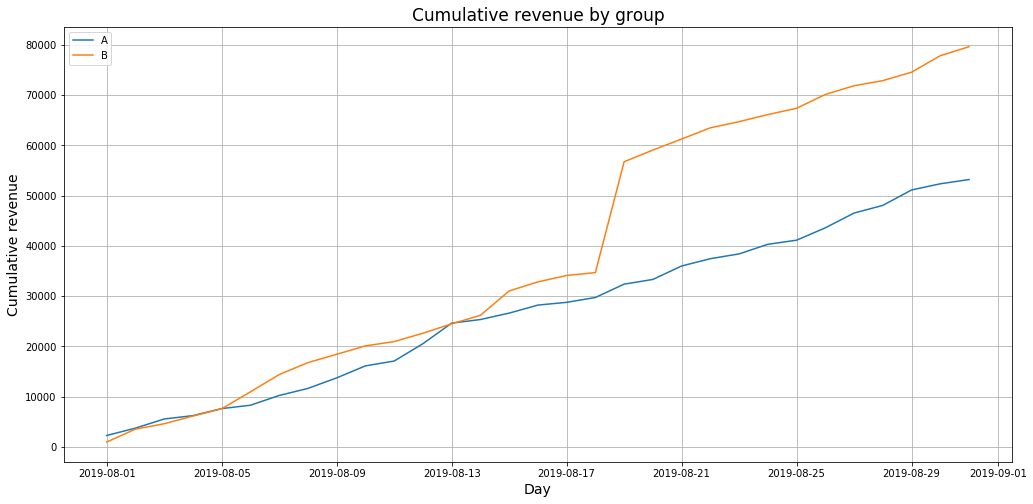

In [32]:
fig,ax=plt.subplots(figsize=(17,8))

ax = plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

ax= plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('Cumulative revenue by group',fontdict={'size':17})
plt.xlabel('Day',fontdict={'size':14})
plt.ylabel('Cumulative revenue',fontdict={'size':14})
plt.legend()
plt.grid()
plt.show()

Plotting the group A and group B revenue graph.

Revenue is rising steadily throughout the whole test which is a good sign.
On the 13th day we can see revenue is the same for both groups. The revenues were also close together at the begining of the test, until the 5th. In the second half of the month revenue for group B grew significantly and then continued at the same pace like the revenue for group A. This may imply either a surge in the number of orders or the presence of very expensive orders in the sample.

### Graph cumulative average order size by group. Make conclusions and conjectures.

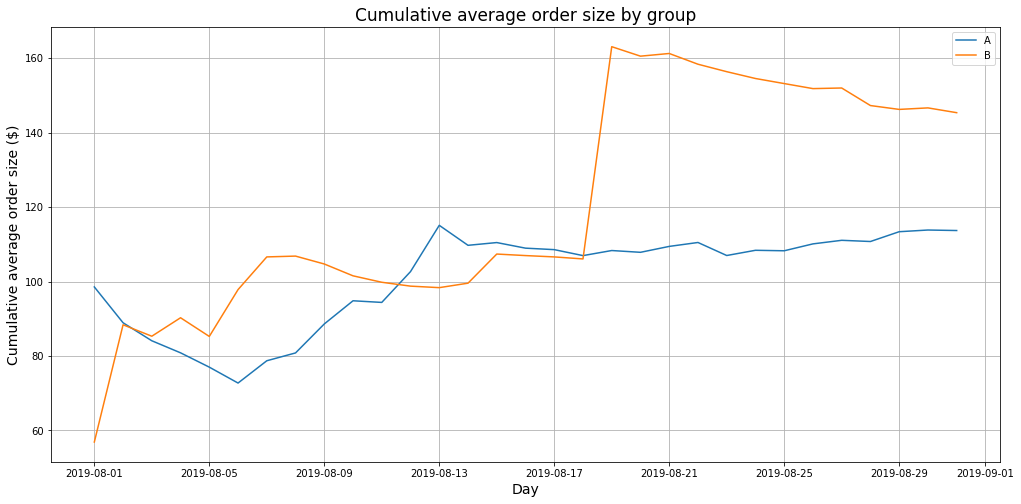

In [33]:
fig,ax=plt.subplots(figsize=(17,8))

ax = plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')

ax= plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('Cumulative average order size by group',fontdict={'size':17})
plt.xlabel('Day',fontdict={'size':14})
plt.ylabel('Cumulative average order size ($)',fontdict={'size':14})
plt.legend()
plt.grid()
plt.show()

Average purchase size becomes steady by the end of the test, too: it stabilizes for group A and keeps on falling for group B. The surge in group B in the second half of the test may have been due to the presence of large, expensive orders. We need more data on this group to find the true average purchase size.

### Graph the relative difference in cumulative average order size for group B compared with group A. Make conclusions and conjectures.

In [34]:
cumulativeRevenueA.head()

,date,revenue,orders
0,2019-08-01,2266.6,23
2,2019-08-02,3734.9,42
4,2019-08-03,5550.1,66
6,2019-08-04,6225.6,77
8,2019-08-05,7623.6,99


In [35]:
cumulativeRevenueB.head()

,date,revenue,orders
1,2019-08-01,967.2,17
3,2019-08-02,3535.3,40
5,2019-08-03,4606.9,54
7,2019-08-04,6138.5,68
9,2019-08-05,7587.8,89


In [36]:
mergedCumulativeRevenue=\
cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

mergedCumulativeRevenue.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,2266.6,23,967.2,17
1,2019-08-02,3734.9,42,3535.3,40
2,2019-08-03,5550.1,66,4606.9,54
3,2019-08-04,6225.6,77,6138.5,68
4,2019-08-05,7623.6,99,7587.8,89


Gathering the data into one DataFrame mergedCumulativeRevenue.

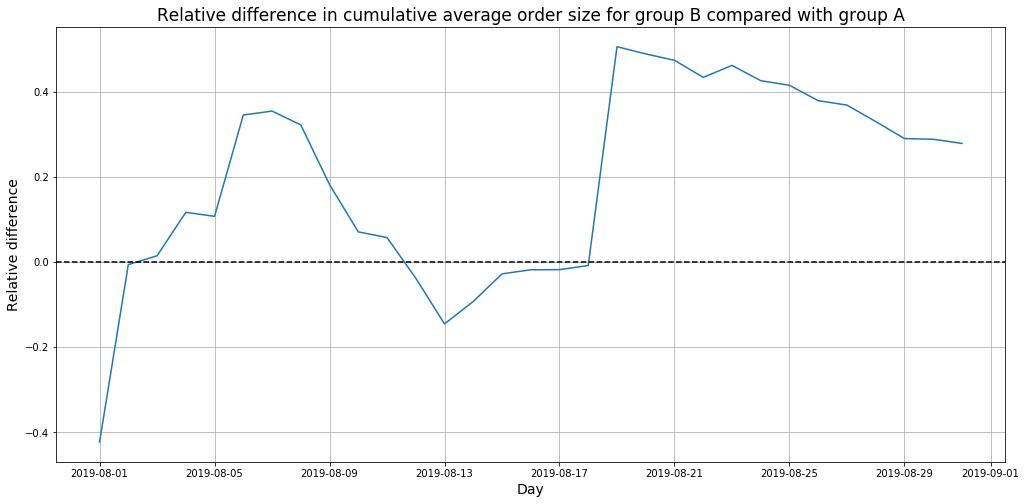

In [37]:
fig,ax=plt.subplots(figsize=(17,8))

# plotting a relative difference graph for the average purchase sizes
ax = plt.plot(
    mergedCumulativeRevenue['date'],
    (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# adding the X axis
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('Relative difference in cumulative average order size for group B compared with group A',fontdict={'size':17})
plt.xlabel('Day',fontdict={'size':14})
plt.ylabel('Relative difference',fontdict={'size':14})
plt.grid()
plt.show()

At several points the difference between the segments spikes. This means there must be some big orders and outliers. Looking at this graph from the raw data, we can say the average order size is in favour of group B.

### Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make conjectures.

In [38]:
cumulativeData.head()

,date,group,orders,buyers,revenue,visits
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845


In [39]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visits']
cumulativeData.head()

,date,group,orders,buyers,revenue,visits,conversion
0,2019-08-01,A,23,19,2266.6,719,0.031989
1,2019-08-01,B,17,17,967.2,713,0.023843
2,2019-08-02,A,42,36,3734.9,1338,0.031390
3,2019-08-02,B,40,39,3535.3,1294,0.030912
4,2019-08-03,A,66,60,5550.1,1845,0.035772


Calculating cumulative conversion.

In [40]:
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

Selecting data on group A and B.

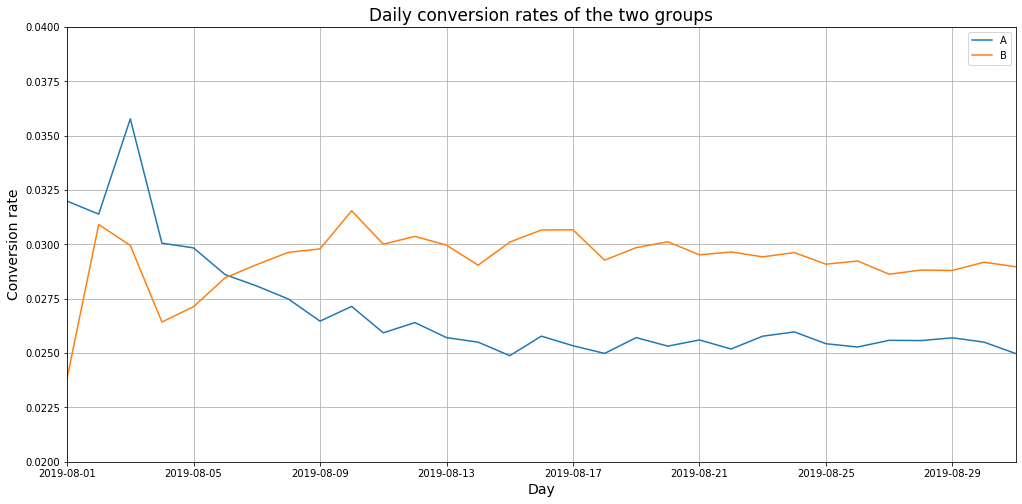

In [41]:
fig,ax=plt.subplots(figsize=(17,8))

ax = plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
ax = plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.title('Daily conversion rates of the two groups',fontdict={'size':17})
plt.xlabel('Day',fontdict={'size':14})
plt.ylabel('Conversion rate',fontdict={'size':14})
plt.legend()

# setting the axes' scale
plt.axis(["2019-08-01", '2019-08-31', 0.02, 0.04])
plt.grid()
plt.show()

We got almost a symmetrical graph! The groups were fluctuating around the same value. Conversion rate of group B is higer than the converion rate for group A, even though it was other way around uo to the 6th day, with more fluctuation than at the end of the test.

### Plot a scatter chart of the number of orders per user. Make conclusions and conjectures.

In [42]:
orders_clean.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [43]:
ordersByUsers = (
    orders_clean.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

Here I have grouped orders_clean data by transactionId and counted their orders.

In [44]:
ordersByUsers.columns = ['userId', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,userId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


The maximum number of orders by user is 3.

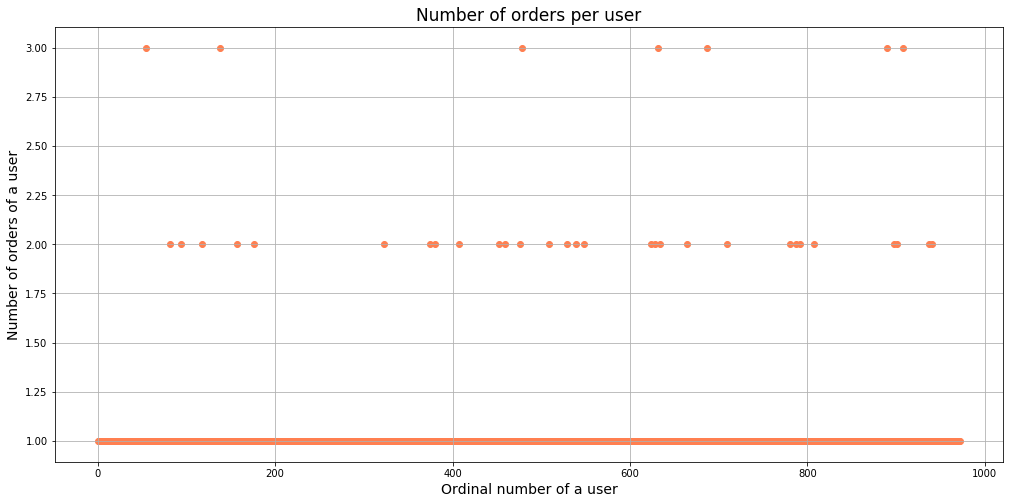

In [45]:
fig,ax=plt.subplots(figsize=(17,8))

x_values = pd.Series(range(0,len(ordersByUsers)))
ax = plt.scatter(x_values, ordersByUsers['orders'],c='coral') 

plt.title('Number of orders per user',fontdict={'size':17})
plt.xlabel('Ordinal number of a user',fontdict={'size':14})
plt.ylabel('Number of orders of a user',fontdict={'size':14})
plt.grid()
plt.show()

Now on this chart we see that the most of the users made only one order and there are only 7 users that made 3 orders, which is tha maximum number of orders in this test. It seems that number of three orders fall in the categorie of anomaly data points and we should exclude them when making the final test results.

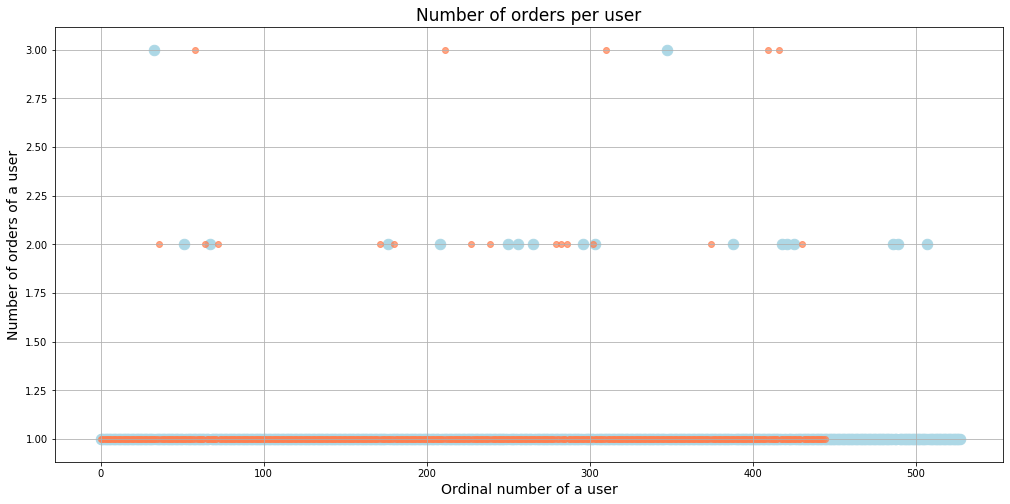

In [46]:
tmp_df = (orders_clean.groupby(['group', 'visitorId'], as_index=False)
          .agg({'transactionId': pd.Series.nunique}))

fig,ax=plt.subplots(figsize=(17,8))

x_values_A = pd.Series(range(0,len(tmp_df.query('group == "A"'))))
x_values_B = pd.Series(range(0,len(tmp_df.query('group == "B"'))))

ax = plt.scatter(x_values_B, tmp_df.query('group == "B"')['transactionId'], c='lightblue', label = "Group B", s = 110)
ax = plt.scatter(x_values_A, tmp_df.query('group == "A"')['transactionId'], c='coral', label = "Group A", alpha = 0.7) 
  
plt.title('Number of orders per user',fontdict={'size':17})
plt.xlabel('Ordinal number of a user',fontdict={'size':14})
plt.ylabel('Number of orders of a user',fontdict={'size':14})
plt.grid()
plt.show()

### Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.

In [47]:
ordersByUsers.head()

,userId,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


In [48]:
np.percentile(ordersByUsers['orders'],[95,99])

array([1., 2.])

Not more than 5% of number of orders per user are higher than 1 order. Not more than 1% of number of orders per user is higher than 2 orders.

I will consider more than 2 orders to be an anomaly data point.

### Plot a scatter chart of order prices. Make conclusions and conjectures.

In [49]:
orders_clean.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [50]:
pricesByOrders = (
    orders_clean.drop(['group','date','visitorId'], axis=1)
    .groupby('transactionId', as_index=False)['revenue'].sum()
)

Here I grouped orders_clean by transactionId and summed their order sizes.

In [51]:
pricesByOrders.head()

,transactionId,revenue
0,1062393,100.8
1,4919758,40.2
2,7210578,60.5
3,8131427,75.5
4,11068804,75.7


In [52]:
pricesByOrders.columns = ['order', 'price']

pricesByOrders.sort_values(by='price', ascending=False).head(10)

,order,price
143,590470918,19920.4
939,3936777065,3120.1
161,666610489,1425.8
875,3668308183,1335.6
850,3603576309,1050.0
311,1348774318,1025.8
71,316924019,1015.9
310,1347999392,930.0
585,2420050534,905.8
738,3163614039,830.3


The highest order size was 19 920! Difference between the first and the second highest ordes size is more than 16 000! This is a huge difference. 

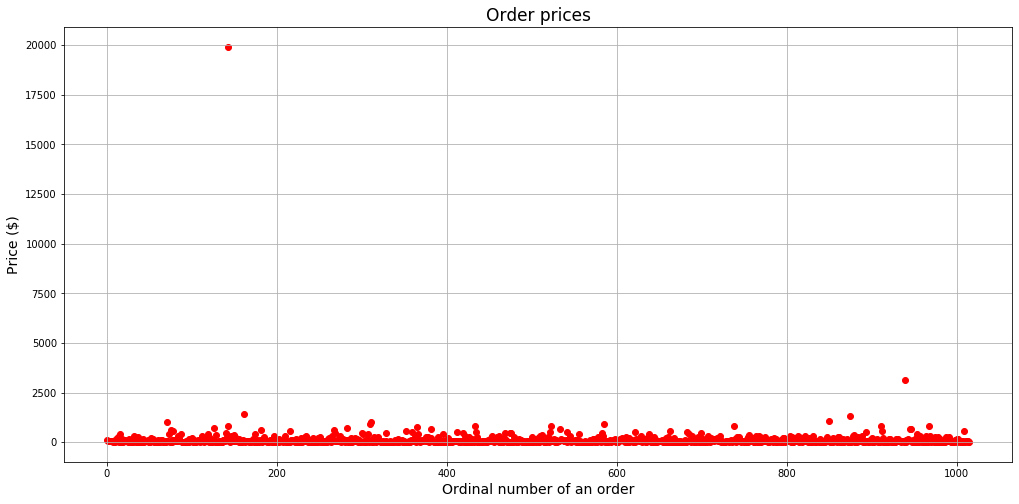

In [53]:
fig,ax=plt.subplots(figsize=(17,8))

x_values = pd.Series(range(0,len(pricesByOrders)))
ax = plt.scatter(x_values, pricesByOrders['price'],c='red') 

plt.title('Order prices',fontdict={'size':17})
plt.xlabel('Ordinal number of an order',fontdict={'size':14})
plt.ylabel('Price ($)',fontdict={'size':14})
plt.grid()
plt.show()

It is actually hard to see dispersion of most of the order prices. Two highest order prices are definetly anomalies.

### Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.

In [54]:
pricesByOrders

,order,price
0,1062393,100.8
1,4919758,40.2
2,7210578,60.5
3,8131427,75.5
4,11068804,75.7
...,...,...
1011,4256972642,35.6
1012,4261512099,50.8
1013,4279408906,15.8
1014,4281129020,60.2


In [55]:
np.percentile(pricesByOrders['price'],[95,99])

array([414.275, 830.3  ])

Not more than 5% of order prices are higher than 414 and not more than 1% of order prices are higher than 830.

I will cosider all the prices higher than 420 to be anomalies.

### Find the statistical significance of the difference in conversion between the groups using the raw data. Make conclusions and conjectures.

In [56]:
cumulativeDataA.head()

,date,group,orders,buyers,revenue,visits,conversion
0,2019-08-01,A,23,19,2266.6,719,0.031989
2,2019-08-02,A,42,36,3734.9,1338,0.031390
4,2019-08-03,A,66,60,5550.1,1845,0.035772
6,2019-08-04,A,77,71,6225.6,2562,0.030055
8,2019-08-05,A,99,92,7623.6,3318,0.029837


H0 ="Distribution of coversion in group A is normal."; null hypothesis.

H1 ="Distribution of coversion in group A is not normal."; alternative hypothesis.

(statistical significance level) alpha = 0.05

Now I will use Shapiro-Wilk test to check is the conversion normally distributed. 

In [57]:
st.shapiro(cumulativeDataA['conversion'])

(0.7151898741722107, 1.962615215234109e-06)

p-value is smaller than alpha so we can reject the null hypothesis. Alternative hypothesis is most likely true; "Distribution of coversion in group A is not normal."

In [58]:
cumulativeDataB.head()

,date,group,orders,buyers,revenue,visits,conversion
1,2019-08-01,B,17,17,967.2,713,0.023843
3,2019-08-02,B,40,39,3535.3,1294,0.030912
5,2019-08-03,B,54,53,4606.9,1803,0.029950
7,2019-08-04,B,68,66,6138.5,2573,0.026428
9,2019-08-05,B,89,87,7587.8,3280,0.027134


H0 ="Distribution of coversion in group B is normal."; null hypothesis.

H1 ="Distribution of coversion in group B is not normal."; alternative hypothesis.

(statistical significance level) alpha = 0.05

I will again use Shapiro-Wilk test to check is the conversion normally distributed. 

In [59]:
st.shapiro(cumulativeDataB['conversion'])

(0.815384030342102, 0.00010078810009872541)

p-value is smaller than alpha so we can reject the null hypothesis. Alternative hypothesis is most likely true; "Distribution of coversion in group B is not normal."

The Mann-Whitney U test is used to compare differences between two independent groups when the dependent variable is either ordinal or continuous, but not normally distributed. Considering conversion values being continuous and not normally distributed; we can perform the mannwhitneyu() statistical test.

H0 ="There´s no statistically significant difference in conversion between group A and group B."; null hypothesis.

H1 ="There is a statistically significant difference in conversion between group A and group B."; alternative hypothesis.

(statistical significance level) alpha = 0.05

In [60]:
st.mannwhitneyu(cumulativeDataA['conversion'],cumulativeDataB['conversion'])

MannwhitneyuResult(statistic=172.0, pvalue=7.248330876119314e-06)

Considering statistical significance level 0.05, our p-value from the mannwhitneyu test is smaller than 0.05 so we can reject the null hypothesis that there´s not a statistically significant difference in conversion between groups.

Alternative hypothesis is most likely to be accurate; there is a statistically significant difference in conversion between groups.

In [61]:
conversions_pivot = pd.pivot_table(cumulativeData,index='date',columns='group',values='conversion')
conversions_pivot['ratio'] = conversions_pivot['B']/conversions_pivot['A']
conversions_pivot = conversions_pivot.sort_values(by='ratio')
conversions_pivot

group,A,B,ratio
date,,,
2019-08-01,0.031989,0.023843,0.745350
2019-08-03,0.035772,0.029950,0.837241
2019-08-04,0.030055,0.026428,0.879341
2019-08-05,0.029837,0.027134,0.909405
2019-08-02,0.031390,0.030912,0.984765
2019-08-06,0.028607,0.028463,0.994940
2019-08-07,0.028084,0.029070,1.035107
2019-08-08,0.027486,0.029634,1.078136
2019-08-27,0.025586,0.028627,1.118835


Looking at the ratio column we can see that the values are very close to one or greater than one; in favour of conversion ratio in group B.

### Find the statistical significance of the difference in average order size between the groups using the raw data. Make conclusions and conjectures.

In [62]:
cumulativeDataA.head()

,date,group,orders,buyers,revenue,visits,conversion
0,2019-08-01,A,23,19,2266.6,719,0.031989
2,2019-08-02,A,42,36,3734.9,1338,0.031390
4,2019-08-03,A,66,60,5550.1,1845,0.035772
6,2019-08-04,A,77,71,6225.6,2562,0.030055
8,2019-08-05,A,99,92,7623.6,3318,0.029837


In [63]:
cumulativeDataB.head()

,date,group,orders,buyers,revenue,visits,conversion
1,2019-08-01,B,17,17,967.2,713,0.023843
3,2019-08-02,B,40,39,3535.3,1294,0.030912
5,2019-08-03,B,54,53,4606.9,1803,0.029950
7,2019-08-04,B,68,66,6138.5,2573,0.026428
9,2019-08-05,B,89,87,7587.8,3280,0.027134


Now we can see that the revenue values are continuous. Now we just need to chech the normality of the distribution.

H0 ="Distribution of ordes sizes in group A is normal."; null hypothesis.

H1 ="Distribution of ordes sizes in group A is not normal."; alternative hypothesis.

(statistical significance level) alpha = 0.05

Now I will use Shapiro-Wilk test to check is the conversion normally distributed. 

In [64]:
st.shapiro(cumulativeDataA['revenue'])

(0.9491177201271057, 0.14759165048599243)

p-value is greater than alpha so there is no reason to reject null hypothesis; Distribution of ordes sizes in group A is normal.

H0 ="Distribution of ordes sizes in group B is normal."; null hypothesis.

H1 ="Distribution of ordes sizes in group B is not normal."; alternative hypothesis.

(statistical significance level) alpha = 0.05

Now I will use Shapiro-Wilk test to check is the conversion normally distributed. 

In [65]:
st.shapiro(cumulativeDataB['revenue'])

(0.8930923938751221, 0.00486730644479394)

p-value is smaller than alpha so we can reject the null hypothesis. Alternative hypothesis is most likely true: Distribution of ordes sizes in group B is not normal.

Now we have got one normal and one not normal distribution of data so we can again use the mannwhitneyu test.

H0 ="There´s no statistically significant difference in order size between group A and group B."; null hypothesis.

H1 ="There is a statistically significant difference in order size between group A and group B."; alternative hypothesis.

(statistical significance level) alpha = 0.05

In [66]:
st.mannwhitneyu(cumulativeDataA['revenue'],cumulativeDataB['revenue'])

MannwhitneyuResult(statistic=373.0, pvalue=0.06598131478574253)

Considering statistical significance level 0.05, our p-value from the mannwhitneyu test is greater than 0.05 so we can´t reject the null hypothesis that there´s not a statistically significant difference in average order size between the groups.

### Find the statistical significance of the difference in conversion between the groups using the filtered data. Make conclusions and conjectures.

I have decided to treat every number of orders greater than 2 and any order size greather than 414.275 to be an outlier.

In [67]:
orders_clean.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [68]:
users_with_many_orders = pd.concat([orders_by_users_A[orders_by_users_A['transactions']>2]['visitorId'],\
                                    orders_by_users_B[orders_by_users_B['transactions']>2]['visitorId']],axis=0)
users_with_many_orders

58      611059232
211    2108163459
310    2988190573
409    3908431265
416    3967698036
33      249864742
347    2742574263
Name: visitorId, dtype: int64

Here I extracted the users from group A and B which had more than 2 transactions.

In [69]:
revenue_lim = np.percentile(pricesByOrders['price'],95) 
revenue_lim

414.275

In [70]:
users_with_expensive_orders = orders_clean[orders_clean['revenue'] > revenue_lim]['visitorId']

Here I extracted the users from group A and B which had order sizer higher than 420.

In [71]:
abnormal_user = pd.concat([users_with_many_orders,users_with_expensive_orders],axis=0).drop_duplicates().sort_values()
len(abnormal_user)

58

Here I merged users_with_many_orders and users_with_expensive_orders to the abnormal_user. There are 58 of them all together.

Now we will calculate the statistical significance of the differences in conversion between the groups, using filtered data.

In [72]:
orders_clean_filtered = orders_clean[~orders_clean['visitorId'].isin(abnormal_user)]
orders_clean_filtered

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1190,38478481,1197745035,2019-08-14,135.3,B
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A


I excluded abnormal users from orders_clean and called it orders_clean_filtered frame.

In [73]:
datesGroups_filtered = orders_clean_filtered[['date','group']].drop_duplicates()
datesGroups_filtered

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


I will repeat the same code steps for filtered data to get the cumulativeData_filtered​.

In [74]:
ordersAggregated_filtered = (datesGroups_filtered\
    .apply(lambda x: orders_clean_filtered[ np.logical_and( orders_clean_filtered['date'] <= x['date'], orders_clean_filtered['group'] == x['group'] )]\
    .agg({'date':'max','group':'max','transactionId':pd.Series.nunique,'visitorId': pd.Series.nunique,'revenue':'sum'}),axis=1)\
    .sort_values(by=['date','group'])
)

In [75]:
ordersAggregated_filtered

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,16,15,883.2
66,2019-08-01,B,17,17,967.2
175,2019-08-02,A,34,32,2321.5
174,2019-08-02,B,38,37,2469.7
291,2019-08-03,A,58,56,4136.7
...,...,...,...,...,...
533,2019-08-29,B,479,463,37010.8
790,2019-08-30,A,422,410,34239.8
690,2019-08-30,B,497,481,38526.6
958,2019-08-31,A,430,418,35088.1


Here we got ordersAggregated_filtered.

In [76]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [77]:
visitorsAggregated_filtered = datesGroups_filtered.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])]\
    .agg({'date':'max','group':'max','visits':'sum'}),axis=1)\
    .sort_values(by=['date','group'])

In [78]:
visitorsAggregated_filtered

,date,group,visits
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
174,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
533,2019-08-29,B,17708
790,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


Here we got visitorsAggregated_filtered.

In [79]:
cumulativeData_filtered = ordersAggregated_filtered.merge(visitorsAggregated_filtered, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData_filtered.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visits']
cumulativeData_filtered

,date,group,orders,buyers,revenue,visits
0,2019-08-01,A,16,15,883.2,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,34,32,2321.5,1338
3,2019-08-02,B,38,37,2469.7,1294
4,2019-08-03,A,58,56,4136.7,1845
...,...,...,...,...,...,...
57,2019-08-29,B,479,463,37010.8,17708
58,2019-08-30,A,422,410,34239.8,18037
59,2019-08-30,B,497,481,38526.6,18198
60,2019-08-31,A,430,418,35088.1,18736


Merging together ordersAggregated_filtered and visitorsAggregated_filtered we got cumulativeData_filtered.

In [80]:
cumulativeRevenueA_filtered = cumulativeData_filtered[cumulativeData_filtered['group']=='A']
cumulativeRevenueB_filtered = cumulativeData_filtered[cumulativeData_filtered['group']=='B']

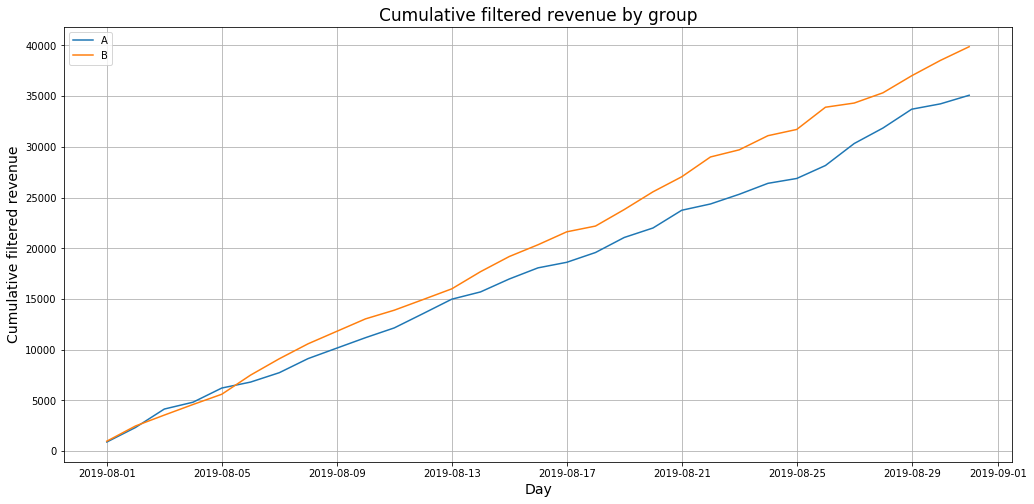

In [81]:
fig,ax=plt.subplots(figsize=(17,8))

ax = plt.plot(cumulativeRevenueA_filtered['date'], cumulativeRevenueA_filtered['revenue'], label='A')

ax= plt.plot(cumulativeRevenueB_filtered['date'], cumulativeRevenueB_filtered['revenue'], label='B')

plt.title('Cumulative filtered revenue by group',fontdict={'size':17})
plt.xlabel('Day',fontdict={'size':14})
plt.ylabel('Cumulative filtered revenue',fontdict={'size':14})
plt.legend()
plt.grid()
plt.show()

After filtering the data from outliers we can see the conversions don´t fluctuate any more. We can also see the cumulative revenue for group B to be higher.

In [82]:
cumulativeData_filtered['conversion'] = cumulativeData_filtered['orders']/cumulativeData_filtered['visits']
cumulativeData_filtered

,date,group,orders,buyers,revenue,visits,conversion
0,2019-08-01,A,16,15,883.2,719,0.022253
1,2019-08-01,B,17,17,967.2,713,0.023843
2,2019-08-02,A,34,32,2321.5,1338,0.025411
3,2019-08-02,B,38,37,2469.7,1294,0.029366
4,2019-08-03,A,58,56,4136.7,1845,0.031436
...,...,...,...,...,...,...,...
57,2019-08-29,B,479,463,37010.8,17708,0.027050
58,2019-08-30,A,422,410,34239.8,18037,0.023396
59,2019-08-30,B,497,481,38526.6,18198,0.027311
60,2019-08-31,A,430,418,35088.1,18736,0.022950


I added conversions for cumulativeData_filtered.

In [83]:
cumulativeDataA_filtered = cumulativeData_filtered[cumulativeData_filtered['group']=='A']
cumulativeDataB_filtered = cumulativeData_filtered[cumulativeData_filtered['group']=='B']

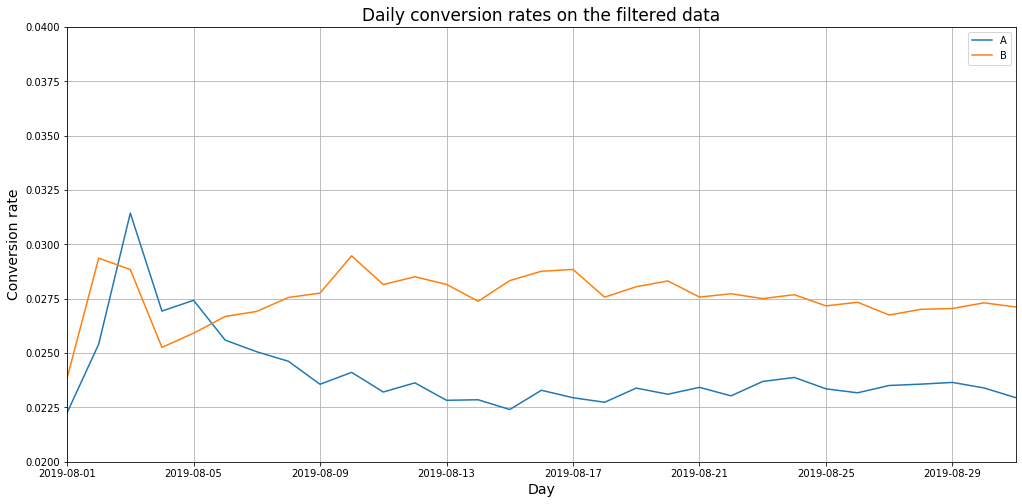

In [84]:
fig,ax=plt.subplots(figsize=(17,8))

ax = plt.plot(cumulativeDataA_filtered['date'], cumulativeDataA_filtered['conversion'], label='A')
ax = plt.plot(cumulativeDataB_filtered['date'], cumulativeDataB_filtered['conversion'], label='B')

plt.title('Daily conversion rates on the filtered data',fontdict={'size':17})
plt.xlabel('Day',fontdict={'size':14})
plt.ylabel('Conversion rate',fontdict={'size':14})
plt.legend()

# setting the axes' scale
plt.axis(["2019-08-01", '2019-08-31', 0.02, 0.04])
plt.grid()
plt.show()

Again we got almost a symmetrical graph! The groups were fluctuating around the same value, which is now a bit lower than by the raw data. Conversion rate of group B is still higer than the converion rate for group A from the 6th day. 

Let´s check the distributions of conversions in group A and group B.

H0 ="Distribution of filtered data of coversion in group A is normal."; null hypothesis.

H1 ="Distribution of filtered data of coversion in group A is not normal."; alternative hypothesis.

(statistical significance level) alpha = 0.05

I will again use Shapiro-Wilk test to check is the conversion normally distributed. 

In [85]:
st.shapiro(cumulativeDataA_filtered['conversion'])

(0.6973452568054199, 1.0622104582580505e-06)

p-value is smaller than alpha so we can reject null hypothesis and accept the alternative: Distribution of filtered data of coversion in group A is not normal.

H0 ="Distribution of filtered data of coversion in group B is normal."; null hypothesis.

H1 ="Distribution of filtered data of coversion in group B is not normal."; alternative hypothesis.

(statistical significance level) alpha = 0.05

I will again use Shapiro-Wilk test to check is the conversion normally distributed. 

In [86]:
st.shapiro(cumulativeDataB_filtered['conversion'])

(0.9248768091201782, 0.03186464309692383)

p-value is smaller than alpha so we can reject null hypothesis and accept the alternative: Distribution of filtered data of coversion in group B is not normal.

Now, having not normal distibutions and continous variables we can perform the mannwhitneyu statistical test.

In [87]:
st.mannwhitneyu(cumulativeDataA_filtered['conversion'],cumulativeDataB_filtered['conversion'])

MannwhitneyuResult(statistic=58.0, pvalue=1.4150779630591875e-09)

p-value is now 1.4150779630591875e-09, with the raw data it was around 7.2e-6. After filtering the data, the p-value is even smaller now. This just confirms us to reject the null hypothesis that there´s not a statistically significant difference in conversion between groups.

Alternative hypothesis is most likely to be accurate; there is a statistically significant difference in conversion between groups.

### Find the statistical significance of the difference in average order size between the groups using the filtered data. Make conclusions and conjectures.

In [88]:
cumulativeDataA_filtered.head()

,date,group,orders,buyers,revenue,visits,conversion
0,2019-08-01,A,16,15,883.2,719,0.022253
2,2019-08-02,A,34,32,2321.5,1338,0.025411
4,2019-08-03,A,58,56,4136.7,1845,0.031436
6,2019-08-04,A,69,67,4812.2,2562,0.026932
8,2019-08-05,A,91,88,6210.2,3318,0.027426


H0 ="Distribution of filtered data of order size in group A is normal."; null hypothesis.

H1 ="Distribution of filtered data of order size in group A is not normal."; alternative hypothesis.

(statistical significance level) alpha = 0.05

I will again use Shapiro-Wilk test to check is the conversion normally distributed. 

In [89]:
st.shapiro(cumulativeDataA_filtered['revenue'])

(0.9627195000648499, 0.3437090516090393)

p-value is greater than alpha so we should not reject null hypothesis which says that distribution of filtered data of order size in group A is normal.

In [90]:
cumulativeDataB_filtered.head()

,date,group,orders,buyers,revenue,visits,conversion
1,2019-08-01,B,17,17,967.2,713,0.023843
3,2019-08-02,B,38,37,2469.7,1294,0.029366
5,2019-08-03,B,52,51,3541.3,1803,0.028841
7,2019-08-04,B,65,63,4587.6,2573,0.025262
9,2019-08-05,B,85,83,5596.7,3280,0.025915


H0 ="Distribution of filtered data of order size in group B is normal."; null hypothesis.

H1 ="Distribution of filtered data of order size in group B is not normal."; alternative hypothesis.

(statistical significance level) alpha = 0.05

I will again use Shapiro-Wilk test to check is the conversion normally distributed. 

In [91]:
st.shapiro(cumulativeDataB_filtered['revenue'])

(0.9565334916114807, 0.23562654852867126)

p-value is greater than alpha so we should not reject null hypothesis which says that distribution of filtered data of order size in group B is normal.

Even though distribution showed to be normal I can still perform mannwhitneyu test.

In [92]:
st.mannwhitneyu(cumulativeDataA_filtered['revenue'],cumulativeDataA_filtered['revenue'])

MannwhitneyuResult(statistic=480.5, pvalue=0.4971906573322744)

p-value for raw data was around 0.07, which is greater than 0.05 significance level. mannwhitneyu test on filtered data gave us p-value of around 0.5 which tells us the differences would be more noticable if there are any in the raw data. We should not reject the null hypothesis  that there is not a statistically significant difference on average order size between groups.

### Make a decision based on the test results. The possible decisions are:
    1. Stop the test, consider one of the groups the leader.
    2. Stop the test, conclude that there is no difference between the groups.
    3. Continue the test.

I would recommend to stop the test, considering group B being the leader.

[here is a link to the top of the document](#the_top)